# Lesson 3 - RFM

## Author - Lukas Fiorio

## Instructions

- Read data
- Calculate RFM
- Segment customer transactions using Kmeans
- Describe the 2-cluster centroids

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from IPython.display import display

In [2]:
# set package options
pd.set_option('display.max_columns', None) # show all columns

## Read data

This project uses data from Tableau Public on Superstore Transactions, [available here](https://community.tableau.com/s/contentdocument/0694T000001GnpUQAS).

The subset of data we work with is made available for download directly from the University of Washington.

In [3]:
# Locate & load dataset
file = "https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/SuperstoreTransaction.csv"
ss_txn = pd.read_csv(file) # read file into df

We start by previewing the data. We see about 10,000 transactions and 21 attributes.  Visually, it looks like many of the attributes are non-numeric.

In [4]:
print(ss_txn.shape)
ss_txn.head()

(9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


Explicitly examining our data structure shows that other than the few quantitative attributes at the end, our data is indeed mostly string data.

Conveniently, we also see that there are no missing values in our data.

*NB: although `Postal Code` is parsed as numeric, we would treat it as categorical for any analytical purposes.*

In [5]:
ss_txn.info() # data structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

Looking at unique values, we see that our data contains \~10,000 products bought in \~5,000 orders made by \~800 customers.

Furthermore, we can get a sense of the columns with high cardinality versus low cardinality.

Those with low cardinality (e.g. `Ship Mode`, `Segment`, `Region`, etc.) may be good candidates for onehot encoding.  Those with high cardinality would likely need to be sensibly aggregated first (to avoid increasing the dimensionality of our data too significantly).

In [6]:
ss_txn.nunique() # count of unique values in each field

Row ID           9994
Order ID         5009
Order Date       1237
Ship Date        1334
Ship Mode           4
Customer ID       793
Customer Name     793
Segment             3
Country             1
City              531
State              49
Postal Code       631
Region              4
Product ID       1862
Category            3
Sub-Category       17
Product Name     1850
Sales            5825
Quantity           14
Discount           12
Profit           7287
dtype: int64

Describing our numeric fields is really only useful for `Sales`, `Quantity`, `Discount`, and `Profit`.  

We see that a typical order (median) is for about \\$55 with profit just under \$10.  Bsaed on the max values, it looks like our data may skew right (as is typical for financial data).

We apply a lambda function to round the stats for readability.

In [7]:
ss_txn.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))) # data stats

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994,9994,9994,9994,9994,9994
mean,4997.5,55190.4,229.858,3.78957,0.156203,28.6569
std,2885.16,32063.7,623.245,2.22511,0.206452,234.26
min,1,1040,0.444,1,0,-6599.98
25%,2499.25,23223,17.28,2,0,1.72875
50%,4997.5,56430.5,54.49,3,0.2,8.6665
75%,7495.75,90008,209.94,5,0.2,29.364
max,9994,99301,22638.5,14,0.8,8399.98


### Data Prep

In [8]:
# rename columns for consistency
ss_txn.columns = ss_txn.columns.str.replace("-", "_") # replace hyphens
ss_txn.columns = ss_txn.columns.str.replace(" ", "_") # replace white space
ss_txn.columns = ss_txn.columns.str.lower()

In [9]:
# convert date columns to datetime (from object)
ss_txn['order_date'] = pd.to_datetime(ss_txn['order_date'])
ss_txn['ship_date'] = pd.to_datetime(ss_txn['ship_date'])

### Data Visualization

In [10]:
txn_count_daily = ss_txn['order_date'].value_counts().sort_index()
txn_count_daily

2014-01-03     1
2014-01-04     3
2014-01-05     1
2014-01-06     9
2014-01-07     2
              ..
2017-12-26     4
2017-12-27     2
2017-12-28    19
2017-12-29    12
2017-12-30     7
Name: order_date, Length: 1237, dtype: int64

#### Transaction Volume Trends

Plotting transaction counts by day, we see our data spans from January 2014 thru December 2017 (4 years of transactions).  We also see that the data is pretty noisy (fairly volatile from day-to-day).

Applying a 14-day rolling average helps make the long-term upward trend a bit more visible.  We still some seasonal spikes around in the latter half of the year (September, November, December) before dropping back down in January.

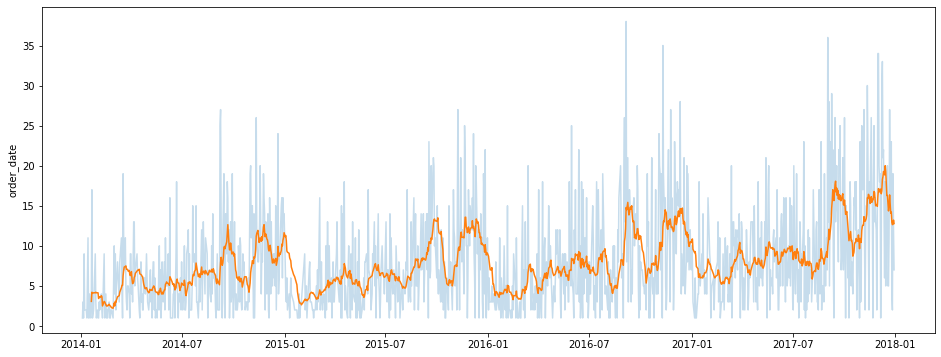

In [11]:
# plot the daily headcount (including a 14 day rolling average)
plt.figure(figsize = (16, 6))
sns.lineplot(x = txn_count_daily.index, y = txn_count_daily, alpha = 0.25);
sns.lineplot(x = txn_count_daily.index, y = txn_count_daily.rolling(14).mean()); # 14day rolling avg

### Calculate RFM

In [12]:
# group by customer id and order date
# aggregate $ sales, # of total products, # of distinct products, # of distinct orders
ss_txn_agg = ss_txn.groupby(['customer_id', 'order_date']).agg({
    'sales': 'sum',
    'quantity': 'sum', 
    'product_id': 'nunique',
    'order_id': 'nunique'
    })
ss_txn_agg = ss_txn_agg.reset_index()

#### examine new structure.  we've aggregated to about half the rows

In [13]:
ss_txn_agg.head() # preview the data

,customer_id,order_date,sales,quantity,product_id,order_id
0,AA-10315,2014-03-31,726.548,4,2,1
1,AA-10315,2014-09-15,29.500,5,2,1
2,AA-10315,2015-10-04,26.960,2,1,1
3,AA-10315,2016-03-03,4406.072,14,4,1
4,AA-10315,2017-06-29,374.480,5,2,1


In [14]:
ss_txn_agg.info() # data structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4992 entries, 0 to 4991
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  4992 non-null   object        
 1   order_date   4992 non-null   datetime64[ns]
 2   sales        4992 non-null   float64       
 3   quantity     4992 non-null   int64         
 4   product_id   4992 non-null   int64         
 5   order_id     4992 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 234.1+ KB


In [15]:
# examine records associated with an arbitrary customer
ss_txn_agg[ss_txn_agg['customer_id']=='CG-12520']

,customer_id,order_date,sales,quantity,product_id,order_id
869,CG-12520,2015-10-15,136.72,7,2,1
870,CG-12520,2016-11-08,993.90,5,2,1
871,CG-12520,2017-01-26,18.16,2,1,1


#### calculate rolling sums on aggregated data

In [16]:
# take rolling sums at each check point, examining past 90 days
roll_sum_sales = ss_txn_agg.groupby('customer_id').rolling(window = '90D', on = 'order_date')['sales'].sum()
roll_cnt_products = ss_txn_agg.groupby('customer_id').rolling(window = '90D', on = 'order_date')['quantity'].sum()
roll_cnt_products_distinct = ss_txn_agg.groupby('customer_id').rolling(window = '90D', on = 'order_date')['product_id'].sum()

In [17]:
# compute recency metric (days since customers last txn)
roll_last_order = ss_txn_agg.groupby('customer_id')['order_date'].diff(periods = 1).dt.days

# calculate max observed recency, for imputation
last_order_imputation = (ss_txn_agg['order_date'].max() - ss_txn_agg['order_date'].min()).days

In [18]:
# combine rolling sum and recency metrics
ss_txn_roll = pd.concat([roll_sum_sales, roll_cnt_products, roll_cnt_products_distinct], axis = 1)
ss_txn_roll.columns = ['dollar_roll_sum_90d', 'product_roll_sum_90d', 'distinct_product_roll_sum_90d']
ss_txn_roll = ss_txn_roll.reset_index()

# if first visit, fill w max date range
ss_txn_roll['last_visit_ndays'] = roll_last_order.fillna(last_order_imputation) 

In [19]:
# inner merge agg & roll (on customer_id, order_date)
ss_txn_rfm = ss_txn_agg.merge(
    ss_txn_roll, 
    how = "inner", 
    on = ['customer_id', 'order_date'], 
    validate = 'one_to_one'
    )

# preview rfm data
ss_txn_rfm.head()

,customer_id,order_date,sales,quantity,product_id,order_id,dollar_roll_sum_90d,product_roll_sum_90d,distinct_product_roll_sum_90d,last_visit_ndays
0,AA-10315,2014-03-31,726.548,4,2,1,726.548,4.0,2.0,1457.0
1,AA-10315,2014-09-15,29.500,5,2,1,29.500,5.0,2.0,168.0
2,AA-10315,2015-10-04,26.960,2,1,1,26.960,2.0,1.0,384.0
3,AA-10315,2016-03-03,4406.072,14,4,1,4406.072,14.0,4.0,151.0
4,AA-10315,2017-06-29,374.480,5,2,1,374.480,5.0,2.0,483.0


In [20]:
ss_txn_rfm.info() # data structure of rfm

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4992 entries, 0 to 4991
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    4992 non-null   object        
 1   order_date                     4992 non-null   datetime64[ns]
 2   sales                          4992 non-null   float64       
 3   quantity                       4992 non-null   int64         
 4   product_id                     4992 non-null   int64         
 5   order_id                       4992 non-null   int64         
 6   dollar_roll_sum_90d            4992 non-null   float64       
 7   product_roll_sum_90d           4992 non-null   float64       
 8   distinct_product_roll_sum_90d  4992 non-null   float64       
 9   last_visit_ndays               4992 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 429.0+ KB


## Segment using kmeans

#### Make a copy of the dataset to handle numeric outliers/normalization for KMeans

In [21]:
# make a copy of the dataset (no pointer)
ss_txn_rfm_scaled = ss_txn_rfm.copy()

#### Normalize the data

- This is important for kmeans as it is a distance-based algorithm
- select relevant numeric columns and z-scale them for use in kmeans
- if data are not scaled, then distances will not be appropriately weighted

In [22]:
# normalize the data
scale_cols = ss_txn_rfm_scaled.columns.difference(['customer_id', 'order_date'], sort = False)
ss_txn_rfm_scaled[scale_cols] = StandardScaler().fit_transform(ss_txn_rfm_scaled[scale_cols]) 

#### initialize & fit kmeans

In [23]:
n_clusters = 2 # set number of clusters

X = ss_txn_rfm_scaled[scale_cols]
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # initialize kmeans
kmeans.fit(X) # train the model

KMeans(n_clusters=2, random_state=0)

In [24]:
# assign cluster to each row of the original RFM data
ss_txn_rfm['cluster'] = kmeans.predict(X) 

In [25]:
ss_txn_rfm.head() # preview the data

,customer_id,order_date,sales,quantity,product_id,order_id,dollar_roll_sum_90d,product_roll_sum_90d,distinct_product_roll_sum_90d,last_visit_ndays,cluster
0,AA-10315,2014-03-31,726.548,4,2,1,726.548,4.0,2.0,1457.0,0
1,AA-10315,2014-09-15,29.500,5,2,1,29.500,5.0,2.0,168.0,0
2,AA-10315,2015-10-04,26.960,2,1,1,26.960,2.0,1.0,384.0,0
3,AA-10315,2016-03-03,4406.072,14,4,1,4406.072,14.0,4.0,151.0,1
4,AA-10315,2017-06-29,374.480,5,2,1,374.480,5.0,2.0,483.0,0


### Examine and describe cluster centers

- **cluster**: <ins>*Large, Frequent Transaction Days*</ins>
  - The smaller cluster (23% of observations).  Defining characteristc: Larger, more frequent transaction days
  - Transactions consist of more products and items
    - However, the item::product ratio is similar to the other cluster, indicating that larger transaction size is primiarily driven by the # of distinct products purchased (not a higher # of each product)
  - Transactions are more frequent, although not overwhelmingly so.
  - Larger rolling window spend, but mostly (not entirely) driven by the transaction itself.
- **cluster**: <ins>*Small, Infrequent Transactoin Days*</ins>
  - The larger cluster (77% of observations).  Defining characteristic: Smaller, less frequent transaction days
  - As opposed to the other cluster, these transactions tend to be smaller (due to fewer products purchased), and a bit less frequent.

In [26]:
# examine cluster centers
pd.DataFrame(kmeans.cluster_centers_, columns=scale_cols)

,sales,quantity,product_id,order_id,dollar_roll_sum_90d,product_roll_sum_90d,distinct_product_roll_sum_90d,last_visit_ndays
0,-0.226494,-0.373551,-0.376214,-0.022648,-0.260411,-0.402840,-0.393806,0.046687
1,0.750739,1.238176,1.247001,0.075069,0.863160,1.335256,1.305312,-0.154748


In [27]:
# relative size of each cluster
round(ss_txn_rfm['cluster'].value_counts(normalize = True).sort_index(),2)

0    0.77
1    0.23
Name: cluster, dtype: float64

In [28]:
# columns to examine means by cluster
display(ss_txn_rfm.groupby(['cluster']).mean())

,sales,quantity,product_id,order_id,dollar_roll_sum_90d,product_roll_sum_90d,distinct_product_roll_sum_90d,last_visit_ndays
cluster,,,,,,,,
0,243.171932,5.256524,1.467380,1.002088,334.811032,7.081681,1.966075,413.542797
1,1177.039670,15.284483,3.761207,1.007759,1642.979568,21.880172,5.461207,313.300000
